<a href="https://colab.research.google.com/github/tuxsy/iebs-master-data-science/blob/main/m06/c3/CrossValidation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intoducción
Normalmente nuestro conjunto de datos originales debemos dividilos en tres subconjuntos:

1.   **Entrenamiento**:  conjunto empleado para entrenar el modelo y optimizar los hiperparámetros del mismo.
2.   **Test**: este es el conjunto que se utilizará para probar el rendimiento de los modelos finales, comprobando que generalizan bien y, por lo tanto, funcionan para datos desconocidos.
3.   **Validación**: es el subconjunto de los datos totales que se utilizará para probar el rendimiento de los modelos **durante la fase entrenamiento**.

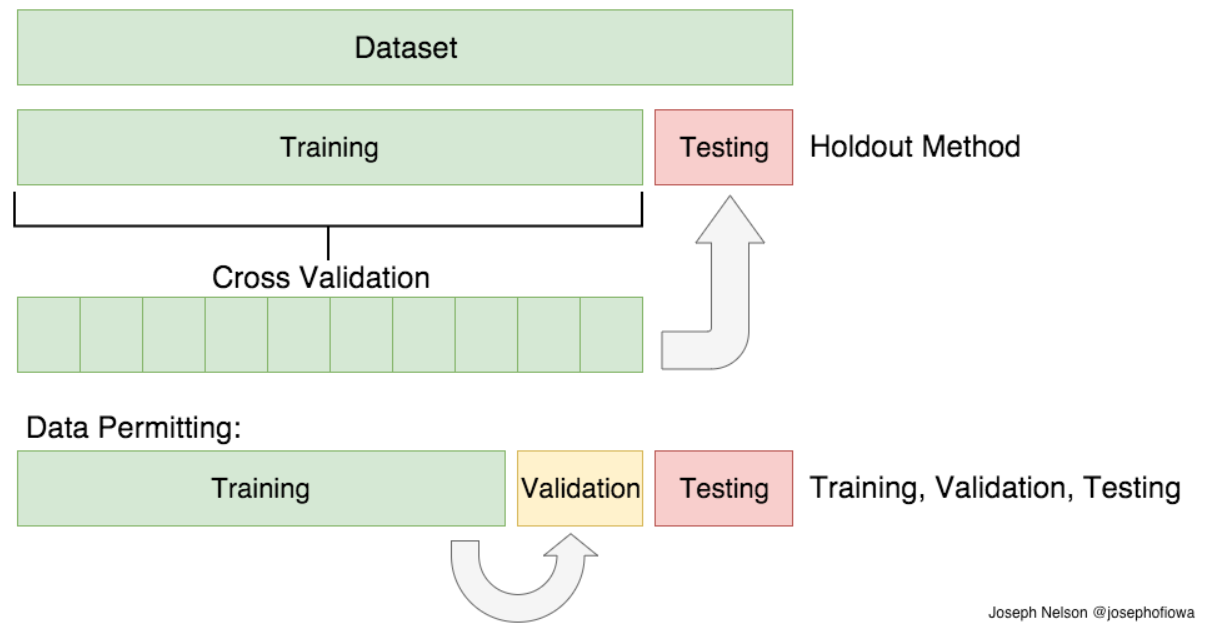

Esta manera de dividir los datos se considera una buena práctica a la hora de entrenar y evaluar la precisión de un modelo. Sin embargo, la creación de estos conjuntos limita el número de datos que se utilizan para el entrenamiento y eso puede **disminuir la capacidad de aprendizaje del modelo**.




Este inconveniente puede solucionarse empleando la técnica de validación cruzada o crossvalidation, la cual tiene las siguientes ventajas frente a la anterionr aproximación.

*   **Ventaja 1**:
La validación cruzada nos permite reducir la necesidad del conjunto de test, puesto que te permite entrenar y testear sobre los mismos datos. Concretamente, este proceso se repite varias veces para que cada observación aparezca al menos una vez en el conjunto de test.
*   **Ventaja 2:**
Este proceso te permite obtener un estimador del rendimiento del modelo más robusto que con la metodología train/test. Puesto que, si solo creas una partición train/test, puede darse el caso de que accidentamente el conjunto de entrenamiento no represente la realidad que quieres modelar y, por lo tanto, a la hora de evaluar sobre nuevos datos dé unos errores excesivamente elevados. La validación cruzada nos permite evaluar el modelo sobre diferentes subconjuntos, tratando de evitar este fenómeno de foma que, aunque para un subconjunto de datos el modelo obtenga unos resultados extraordinarios, estos serán compensados con los de otras particiones para los que lo haga peor. Además, este hecho nos debería hacernos replantear si existen mejores métodos para particionar los datos, de forma que el modelo no sea tan sensible al mismo.







# Validación cruzada en `scikit-learn`

La librería  `scikit-learn` proporciona varios mecanismos para partir los datos en train y test. Los más populares son:



*   **train_test_split** - crea una única división del conjunto de entrenamiento y test.

*   **KFold** - crea divisiones k-fold que permiten la validación cruzada.
*   **StratifiedKFold** - crea divisiones k-fold considerando la distribución de la variable objetivo.
*  **cross_val_score** - evalúa la puntuación del modelo mediante validación cruzada de manera transparente para el usuario.

Sin embargo, hay que tener en cuenta que la validación cruzada no es adecuada para todas las ocasiones y hay casos en los que hay pensar bien **cómo dividir los datos**.

Más información sobre crossvalidation: [Scikit-learn](https://scikit-learn.org/stable/modules/cross_validation.html).

In [1]:
# Import scikit-learn libraries
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score
from sklearn.datasets import load_iris, load_boston
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# import libraries for charting and manipulations with datasets
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random

## Cargamos los datos

Vamos a utilizar el popular conjunto de datos de Iris para estudiar mejor los diferentes métodos de validación cruzada.
El conjunto de datos contiene 150 medidas de pétalos y sépalos de las 3 variantes de la flor de Iris: setosa, versicolor y virginica. El conjunto contiene 50 medidas de cada clase.

Iris dataset en `scikit-learn`: https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html

In [2]:
iris = load_iris(return_X_y=False)
iris_df = pd.DataFrame(data=iris.data,columns=iris.feature_names)
features = iris['feature_names']
iris_df['target'] = iris.target
iris_df["target_name"] = iris_df['target'].map({i:name for i,name in enumerate(iris.target_names)})
iris_df.sample(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_name
25,5.0,3.0,1.6,0.2,0,setosa
139,6.9,3.1,5.4,2.1,2,virginica
121,5.6,2.8,4.9,2.0,2,virginica
86,6.7,3.1,4.7,1.5,1,versicolor
93,5.0,2.3,3.3,1.0,1,versicolor


In [3]:
# Let's see how many samples of each iris type we have in our set
pd.DataFrame(iris_df.groupby("target_name").size().reset_index()).rename(columns={0:"samples"})

,target_name,samples
0,setosa,50
1,versicolor,50
2,virginica,50


## Una única división con `train_test_split`

Vamos a realizar una regresión logística empleando el tradicional `train_test_split` que dividirá los datos en el conjunto de entrenamiento y de test, de forma que cada clase aparezca en el conjunto de entrenamiento y de test un número similar de veces.

In [4]:
# initialize the model
model = LogisticRegression(solver="liblinear", multi_class="auto")

In [5]:
#Logistic regression without Kfold, just split into 80% train and 20% test set
X = iris_df[features]
y = iris_df["target"]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [6]:
#Train the model
model.fit(X_train, y_train) #Training the model
pd.DataFrame({"Accurancy on Train":[accuracy_score(y_train, model.predict(X_train))],
    "Accurancy on Test":[accuracy_score(y_test, model.predict(X_test))]})

,Accurancy on Train,Accurancy on Test
0,0.958333,1.0


## KFold




### Introducción al método `KFold`
El método [`KFold`](https://scikit-learn.org/stable/modules/cross_validation.html#k-fold), el cual divide el conjunto de entrenamiento en *k* subconjuntos (k-folds) de forma que cada muestra se usa ona vez para la fase de test y k-1 para entrenar el modelo.

IMPORTANTE: **KFold** devuelve índices, no los datos directamente.

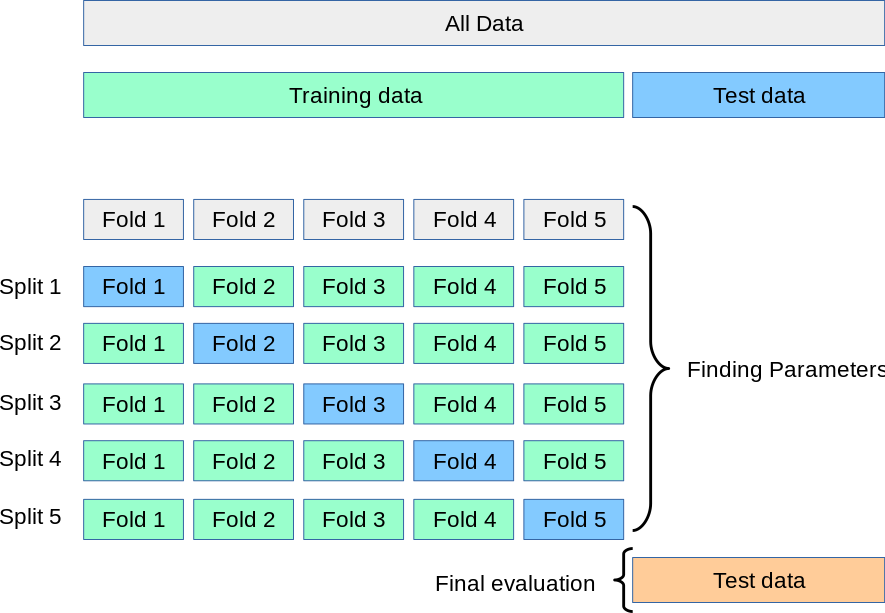

In [7]:
#Creamos el rango 1 a 25
rn = range(1,26)
for i in rn:
  print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


In [8]:
# La función KFold debe aplicarse a los datos y devuelve el índice de las muestras de entrenamiento y de prueba.
kf3 = KFold(n_splits=3, shuffle=False)
kf3

KFold(n_splits=3, random_state=None, shuffle=False)

In [9]:
# la función KFold devuelve los índices de los datos. Nuestro rango va de 1 a 25 por lo que el índice es de 0 a 24
for train_index, test_index in kf3.split(rn):
    print(train_index, test_index)

[ 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] [0 1 2 3 4 5 6 7 8]
[ 0  1  2  3  4  5  6  7  8 17 18 19 20 21 22 23 24] [ 9 10 11 12 13 14 15 16]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] [17 18 19 20 21 22 23 24]


In [10]:
# para obtener los valores de nuestros datos, utilizamos np.take() para acceder a un valor de un índice concreto
for train_index, test_index in kf3.split(rn):
    print(np.take(rn,train_index), np.take(rn,test_index))

[10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25] [1 2 3 4 5 6 7 8 9]
[ 1  2  3  4  5  6  7  8  9 18 19 20 21 22 23 24 25] [10 11 12 13 14 15 16 17]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] [18 19 20 21 22 23 24 25]


## KFold aplicado a los conjunto de datos de iris

El método `KFold` devuelve el orden o índice de las muestras elegidas para los conjuntos de entrenamiento y testeo en cada división (fold). En un dataframe de *pandas* tenemos que usar la función `.iloc` para obtener las filas correctas. Como no he dividido los datos en *X* (atributos) e *y* (objetivo), tengo que usar también `.loc` para elegir las columnas correctas (`.loc[:,características]`) o simplemente elegir las columnas (`['objetivo']`).

In [11]:
i = 1
for train_index, test_index in kf3.split(iris_df):
    X_train = iris_df.iloc[train_index].loc[:, features]
    X_test = iris_df.iloc[test_index][features]
    y_train = iris_df.iloc[train_index].loc[:,'target']
    y_test = iris_df.iloc[test_index]['target']
        
    #Train the model
    model.fit(X_train, y_train) #Training the model
    print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test, model.predict(X_test))}")
    i += 1

Accuracy for the fold no. 1 on the test set: 0.0
Accuracy for the fold no. 2 on the test set: 0.0
Accuracy for the fold no. 3 on the test set: 0.0


Pero, ¿por qué la precisión de cada fold es **0,0**? La razón es la uniformidad de las divisiones. Como los datos están ordenados de forma que setosa aparece en las primeras cincuenta filas del conjunto de datos, seguida de versicolor y virginica, hemos conseguido una distribución única del conjunto de entrenamiento, que no contiene ninguna observación de la misma naturaleza que las que pertenecen al conjunto de prueba. La mayoría de los modelos de aprendizaje automático no pueden aprender a clasificar en una clase que nunca han visto.  Lo cual es visible en la tercera división.

A continuación, vamos a representar de forma gráfica este hecho para que sea más claramente comprensible.

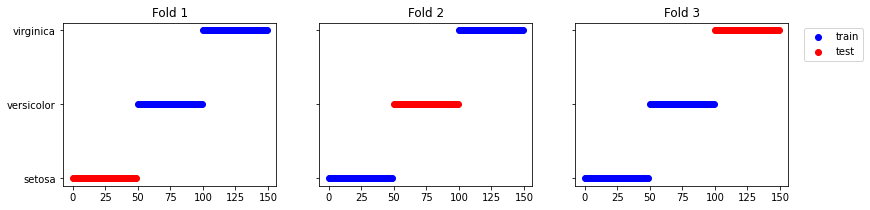

In [12]:
target_name = iris_df["target"]

fig, ax = plt.subplots(1,3, figsize=(13,3), sharey=True)
for i, (train_index, test_index) in enumerate(kf3.split(iris_df)):
    ax[i].scatter(x=train_index,y=target_name.iloc[train_index],label ="train", c='b')
    ax[i].scatter(x=test_index,y=target_name.iloc[test_index], label = "test", c='r')
    ax[i].set_title(f"Fold {i+1}")

ax[0].set_yticks([0,1,2])
ax[0].set_yticklabels(iris["target_names"])
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

Como podemos apreciar, en cada fold el conjunto de test contiene obsevaciones de una **única** clase y, además, esta clase no está presente en el conjunto de entrenamiento. Por lo que es imposible que el algoritmo pueda aprender a clasificar bien este tipo de observaciones.

## Shuffled KFold
Una manera de solucionar esto es utilizando el método **shuffled Kfold**, el cual, 'barajea' los datos antes de dividirlos en lotes o grupos.

Esto se consigue empleando el mismo método `KFold()`pero añadiendo la propiedad `shuffle=True`.

In [13]:
dfs = []
kf = KFold(n_splits=3, shuffle=True, random_state=123)
i = 1

for train_index, test_index in kf.split(iris_df):
    X_train = iris_df.iloc[train_index].loc[:, features]
    X_test = iris_df.iloc[test_index].loc[:,features]
    y_train = iris_df.iloc[train_index].loc[:,'target']
    y_test = iris_df.loc[test_index].loc[:,'target']
    
    #Train the model
    model.fit(X_train, y_train) #Training the model
    y_pred = model.predict(X_test)
    print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test, y_pred)}")
    
    # how many occurences appear in the train set
    s_train = iris_df.iloc[train_index].loc[:,'target_name'].value_counts()
    s_train.name = f"train {i}"
    s_test = iris_df.iloc[test_index].loc[:,'target_name'].value_counts()
    s_test.name = f"test {i}"
    df = pd.concat([s_train, s_test], axis=1, sort=False)
    df["|"] = "|"
    dfs.append(df)
    
    i += 1

Accuracy for the fold no. 1 on the test set: 0.98
Accuracy for the fold no. 2 on the test set: 0.94
Accuracy for the fold no. 3 on the test set: 0.88


Vemos que los resultados han mejorado considerablemente para la partición de test. Vamos a visualizar la distribución de cada clase en los conjunto de train y test.

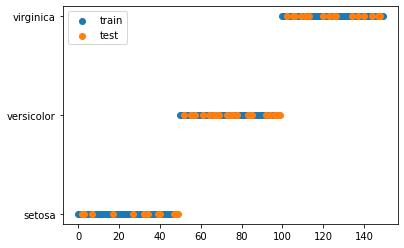

In [14]:
plt.scatter(x=y_train.index,y=iris_df.iloc[train_index].loc[:,'target_name'],label ="train")
plt.scatter(x=y_test.index,y=iris_df.iloc[test_index].loc[:,'target_name'], label = "test")
plt.legend()
plt.show()

Se puede ver que ahora recogemos muestras de los tres tipos de iris, aunque algunos se eligen con más frecuencia que otros. 

In [15]:
pd.concat(dfs,axis=1, sort=False)

,train 1,test 1,|,train 2,test 2,|,train 3,test 3,|
versicolor,39,11,|,33,17,|,28,22,|
virginica,31,19,|,35,15,|,34,16,|
setosa,30,20,|,32,18,|,38,12,|


## Stratified KFold

En lugar de utilizar KFold aleatorio, podemos utilizar **Stratified KFold** o KFold estratificado, el cual necesita el parámetro extra `y`. Siendo `y` la variable objetivo, de forma que el método KFold pueda escoger muestras con una distribución equilibrada de la variable objetivo en cada fold.

In [16]:
dfs = []
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=123)
i = 1
for train_index, test_index in kf.split(iris_df, iris_df["target"]):
    X_train = iris_df.iloc[train_index].loc[:, features]
    X_test = iris_df.iloc[test_index].loc[:,features]
    y_train = iris_df.iloc[train_index].loc[:,'target']
    y_test = iris_df.loc[test_index].loc[:,'target']

    #Train the model
    model.fit(X_train, y_train) #Training the model
    print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test, model.predict(X_test))}, doublecheck: {model.score(X_test,y_test)}")
    
    # how many occurences appear in the train set
    s_train = iris_df.iloc[train_index].loc[:,'target_name'].value_counts()
    s_train.name = f"train {i}"
    s_test = iris_df.iloc[test_index].loc[:,'target_name'].value_counts()
    s_test.name = f"test {i}"
    df = pd.concat([s_train, s_test], axis=1, sort=False)
    df["|"] = "|"
    dfs.append(df)
    
    i += 1

Accuracy for the fold no. 1 on the test set: 0.94, doublecheck: 0.94
Accuracy for the fold no. 2 on the test set: 0.98, doublecheck: 0.98
Accuracy for the fold no. 3 on the test set: 0.92, doublecheck: 0.92


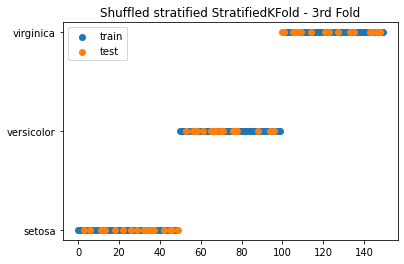

In [17]:
plt.scatter(x=y_train.index,y=iris_df.iloc[train_index].loc[:,'target_name'],label ="train")
plt.scatter(x=y_test.index,y=iris_df.iloc[test_index].loc[:,'target_name'], label = "test")
plt.legend()
plt.title("Shuffled stratified StratifiedKFold - 3rd Fold")
plt.show()

In [18]:
pd.concat(dfs,axis=1, sort=False)

,train 1,test 1,|,train 2,test 2,|,train 3,test 3,|
virginica,34,16,|,33,17,|,33,17,|
setosa,33,17,|,33,17,|,34,16,|
versicolor,33,17,|,34,16,|,33,17,|


Vemos que con el método `StratifiedKFold`obtenemos una distribución mucho más homogénea de las diferentes clases en cada fold.

## Validación cruzada sin KFold

Si no quieres jugar con la división de los datos, no tienes que hacer KFolds. Puedes utilizar las clases `cross_validate` o `cross_val_score`, las cuales entrenarán automáticamente tu modelo empleando los datos que le especifiques y el número preferido de divisiones, y te dará la puntuación en el conjunto de test. Veamos cómo se hace.

In [19]:
# cross_validate te permite especificar la métrica que quieres ver
for i, score in enumerate(cross_validate(model, X,y, cv=3)["test_score"]):
    print(f"Accuracy para el fold nun. {i} en el conjunto de test: {score}")

Accuracy para el fold nun. 0 en el conjunto de test: 0.96
Accuracy para el fold nun. 1 en el conjunto de test: 0.96
Accuracy para el fold nun. 2 en el conjunto de test: 0.94


In [20]:
for i, score in enumerate(cross_val_score(model, X,y, cv=3)):
    print(f"Accuracy para el fold nun. {i} en el conjunto de test: {score}")

Accuracy para el fold nun. 0 en el conjunto de test: 0.96
Accuracy para el fold nun. 1 en el conjunto de test: 0.96
Accuracy para el fold nun. 2 en el conjunto de test: 0.94


## Otros métodos de validación cruzada

### ShuffleSplit
https://scikit-learn.org/stable/modules/cross_validation.html#random-permutations-cross-validation-a-k-a-shuffle-split

Mientras que KFold se asegura de que cada muestra aparezca una vez en el conjunto de pruebas, con ShuffleSplit se especifica cuántas muestras hay en el conjunto de pruebas. Shuffle Split estratificado consideraría la distribución de la variable objetivo.

### Leave One Out

https://scikit-learn.org/stable/modules/cross_validation.html#leave-one-out-loo

Leave One Out hace justamente lo que dice: sólo deja una única observación como muestra de prueba. 

En la documentación de `scikit-learn` se sugiere: "Como regla general, la mayoría de los autores, y la evidencia empírica, sugieren que se debe preferir la validación cruzada de 5 o 10 folds a la técnica de  LOO".


### Leave P Out


https://scikit-learn.org/stable/modules/cross_validation.html#leave-p-out-lpo

Leave P Out es una generalización del método anterior, pero en lugar de dejar una observación para el conjunto de test, deja *p* observaciones.

Leave P out crea ${n \choose p}$ cobinaciones.

# Conclusion

En este notebook hemos revisado cómo funcionan los métodos `KFold` que implementa `scikit-learn`. Hemos visto que el método `KFold` divide los datos en *k* número de conjuntos o folds. Cada una de la observaciones aparecerá una vez en el conjunto de prueba y *k-1* veces en el conjunto de entrenamiento. También se puede utilizar la opción `shuffle=True`  para obtener una distribución diferente de entrenamiento y test. 

En el KFold normal, cada conjunto o fold contendrá `1/k` valores en el subconjunto de entrenamiento y `k-1/k` valores en el subconjunto de test. Así, para `k=2` el 50% de las observaciones serán para test, para `k=3` el 33%, para `n=4` el 25%, etc. 


Si por el contrario, el usuario no quiere especificar la técnica de KFold, y solo le interesa obtener una estimación robusta de la precisión del modelo, puede realizar el proceso de validación cruzada de manera transparente empleando los métodos `cross-validate` o `cross-val-score`. La división de los datos será transparente para el usuario y simplemente recibirá la puntuación final. 

Un concepto importante es el KFold estratificado, que garantiza que la proporción de la variable objetivo sea la misma en el conjunto de entrenamiento y en el de test. **Esto no garantiza que la proporción de los atributos sea la misma**. Si una de las divisiones muestra una puntuación extraordinariamente baja o alta, significa que la división puede influir en los resultados del modelo y habrá que revisar el proceso con mayor detalle.

Más información: https://towardsdatascience.com/complete-guide-to-pythons-cross-validation-with-examples-a9676b5cac12

